In [1]:
import yfinance as yf
import requests
import pandas as pd
from textblob import TextBlob
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf

In [2]:
import datetime
ticker = 'AMZN'
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=30)
data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), auto_adjust=True)
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed



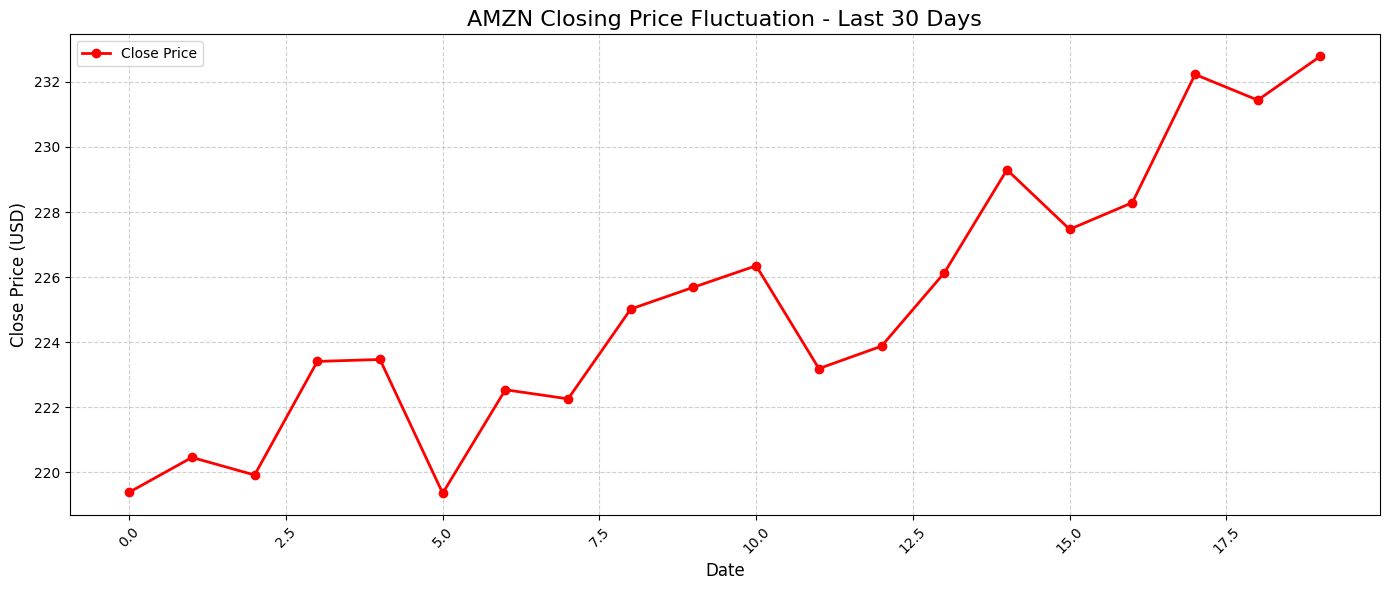

In [3]:
# Drop any rows with missing values
data.dropna(inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='red', marker='o', linewidth=2)
plt.title('AMZN Closing Price Fluctuation - Last 30 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

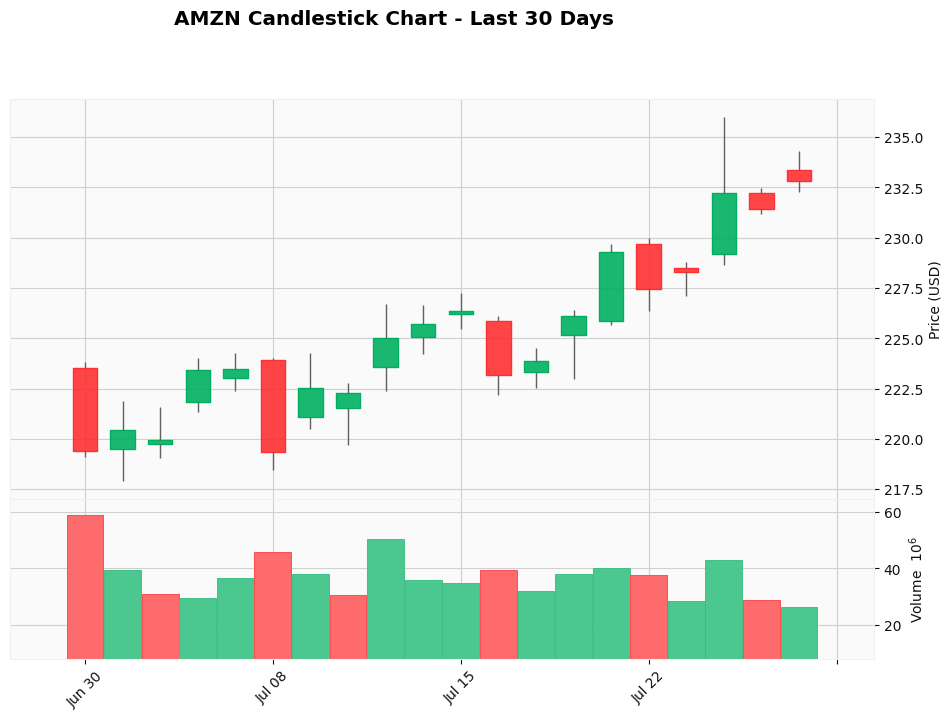

In [4]:
data_flat = data.copy()
data_flat.columns = [col[0] for col in data_flat.columns] 

if 'Date' in data_flat.columns:
    data_flat['Date'] = pd.to_datetime(data_flat['Date'])
    data_flat.set_index('Date', inplace=True)

data_flat.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)

mpf.plot(
    data_flat,
    type='candle',
    style='yahoo',
    title='AMZN Candlestick Chart - Last 30 Days',
    ylabel='Price (USD)',
    volume=True,
    figsize=(12, 8)
)


In [4]:
load_dotenv()
NEWS_API_KEY = os.getenv('NEWS_API_KEY')

def get_news_sentiment(company, date, print_news=False):
    url = ('https://newsapi.org/v2/everything?'
           f'q={company}&from={date}&to={date}&sortBy=relevance&language=en&apiKey={NEWS_API_KEY}')
    response = requests.get(url).json()
    
    if print_news:
        print(f"\n--- News for {company} on {date} ---")
        if 'articles' in response and response['articles']:
            for i, article in enumerate(response['articles'][:5], 1):  # Show top 5 articles
                print(f"{i}. {article['title']}")
                if article.get('description'):
                    print(f"   Description: {article['description'][:150]}...")
                print(f"   Source: {article['source']['name']}")
                print(f"   URL: {article['url']}")
                print()
        else:
            print(f"No articles found for {company} on {date}")
            if 'message' in response:
                print(f"API message: {response['message']}")
    
    sentiments = []
    for article in response.get('articles', []):
        headline = article['title']
        sentiment = TextBlob(headline).sentiment.polarity
        sentiments.append(sentiment)
    
    if sentiments:
        avg_sentiment = sum(sentiments) / len(sentiments)
        if print_news:
            print(f"Average sentiment score: {avg_sentiment:.3f} (Range: -1 to +1)")
            print(f"Number of articles analyzed: {len(sentiments)}")
        return avg_sentiment
    else:
        if print_news:
            print("No sentiment data available")
        return 0

In [5]:
# Test news retrieval and display with multiple dates
import datetime

# Test with different dates to find available news
test_dates = [
    (datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d'),  # Yesterday
    (datetime.date.today() - datetime.timedelta(days=2)).strftime('%Y-%m-%d'),  # 2 days ago
    (datetime.date.today() - datetime.timedelta(days=3)).strftime('%Y-%m-%d'),  # 3 days ago
]

print(f"Testing news retrieval for {ticker}")
print("=" * 50)

for test_date in test_dates:
    print(f"\nTrying date: {test_date}")
    sentiment_score = get_news_sentiment(ticker, test_date, print_news=True)
    print(f"Sentiment score: {sentiment_score}")
    print("-" * 30)
    
    # If we found articles, break after the first successful retrieval
    if sentiment_score != 0:
        break

Testing news retrieval for AMZN

Trying date: 2025-07-28

--- News for AMZN on 2025-07-28 ---
1. Earnings live: Microsoft, Apple, Amazon highlight parade of Q2 results this week
   Description: This week, 112 S&P 500 companies report Q2 results in a busy week for corporate earnings reports....
   Source: Yahoo Entertainment
   URL: https://finance.yahoo.com/news/live/earnings-live-microsoft-apple-amazon-highlight-parade-of-q2-results-this-week-114303064.html

2. Stock market today: Dow, S&P 500, Nasdaq futures trade flat ahead of week poised to shake markets
   Description: US stock futures traded flat as Wall Street prepared for major earnings and economic data ahead of a blockbuster week that could shake markets....
   Source: Yahoo Entertainment
   URL: https://finance.yahoo.com/news/live/stock-market-today-dow-sp-500-nasdaq-futures-trade-flat-ahead-of-week-poised-to-shake-markets-233720236.html

3. Knight And Day 2010 1080p AMZN WEB-DL H264-PiRaTeS
   Description: Awards 3 nominati

In [6]:
# Check data structure and ensure proper datetime handling
print("Data columns:", data.columns.tolist())
print("Data types:", data.dtypes)
print("First few rows:")
print(data.head())

# Flatten the column structure for easier access
data.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data.columns]
print("\nFlattened columns:", data.columns.tolist())

# Ensure Date column is properly formatted
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    print("Date column converted to datetime")

features = []
targets = []

for i in range(len(data) - 1):
    # Get the date value directly using iloc
    current_date = data['Date'].iloc[i]
    date_str = current_date.strftime('%Y-%m-%d')
    
    print(f"Processing date: {date_str}")
    sentiment = get_news_sentiment(ticker, date_str)
    
    # Feature vector: [Close price today, News sentiment today]
    features.append([data['Close_AMZN'].iloc[i], sentiment])
    # Target: Close price next day
    targets.append(data['Close_AMZN'].iloc[i + 1])

print(f"\nCreated {len(features)} feature vectors")
print(f"First 3 features: {features[:3]}")
print(f"First 3 targets: {targets[:3]}")

Data columns: [('Date', ''), ('Close', 'AMZN'), ('High', 'AMZN'), ('Low', 'AMZN'), ('Open', 'AMZN'), ('Volume', 'AMZN')]
Data types: Price   Ticker
Date              datetime64[ns]
Close   AMZN             float64
High    AMZN             float64
Low     AMZN             float64
Open    AMZN             float64
Volume  AMZN               int64
dtype: object
First few rows:
Price        Date       Close        High         Low        Open    Volume
Ticker                   AMZN        AMZN        AMZN        AMZN      AMZN
0      2025-06-30  219.389999  223.820007  219.119995  223.520004  58887800
1      2025-07-01  220.460007  221.880005  217.929993  219.500000  39256800
2      2025-07-02  219.919998  221.600006  219.059998  219.729996  30894200
3      2025-07-03  223.410004  224.009995  221.360001  221.820007  29632400
4      2025-07-07  223.470001  224.289993  222.369995  223.000000  36604100

Flattened columns: ['Date', 'Close_AMZN', 'High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Volume_AMZ

In [7]:
# 4. Train a simple regression model
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train) 

RandomForestRegressor(random_state=42)

In [8]:
# 5. Test & print accuracy (R^2 score)
print("Test R^2 Score:", model.score(X_test, y_test))

# 6. Predict next day price based on latest data
latest_price = data['Close_AMZN'].iloc[-1]  # Get the last closing price
latest_date = data['Date'].iloc[-1].strftime('%Y-%m-%d')  # Get the last date
latest_sentiment = get_news_sentiment(ticker, latest_date)

print(f"\nLatest data for prediction:")
print(f"Date: {latest_date}")
print(f"Latest closing price: ${latest_price:.2f}")
print(f"Latest sentiment score: {latest_sentiment:.3f}")

predicted_price = model.predict([[latest_price, latest_sentiment]])
print(f"\n🔮 Predicted next day price for {ticker}: ${predicted_price[0]:.2f}")

# Calculate prediction change
price_change = predicted_price[0] - latest_price
change_percent = (price_change / latest_price) * 100
print(f"Expected change: ${price_change:+.2f} ({change_percent:+.2f}%)")

if change_percent > 0:
    print("📈 Model predicts price will GO UP")
elif change_percent < 0:
    print("📉 Model predicts price will GO DOWN")
else:
    print("➡️ Model predicts price will stay FLAT")

Test R^2 Score: -1.7504083885721227
 -1.7504083885721227

Latest data for prediction:
Date: 2025-07-28
Latest closing price: $232.79
Latest sentiment score: 0.056

🔮 Predicted next day price for AMZN: $231.26
Expected change: $-1.53 (-0.66%)
📉 Model predicts price will GO DOWN

Latest data for prediction:
Date: 2025-07-28
Latest closing price: $232.79
Latest sentiment score: 0.056

🔮 Predicted next day price for AMZN: $231.26
Expected change: $-1.53 (-0.66%)
📉 Model predicts price will GO DOWN


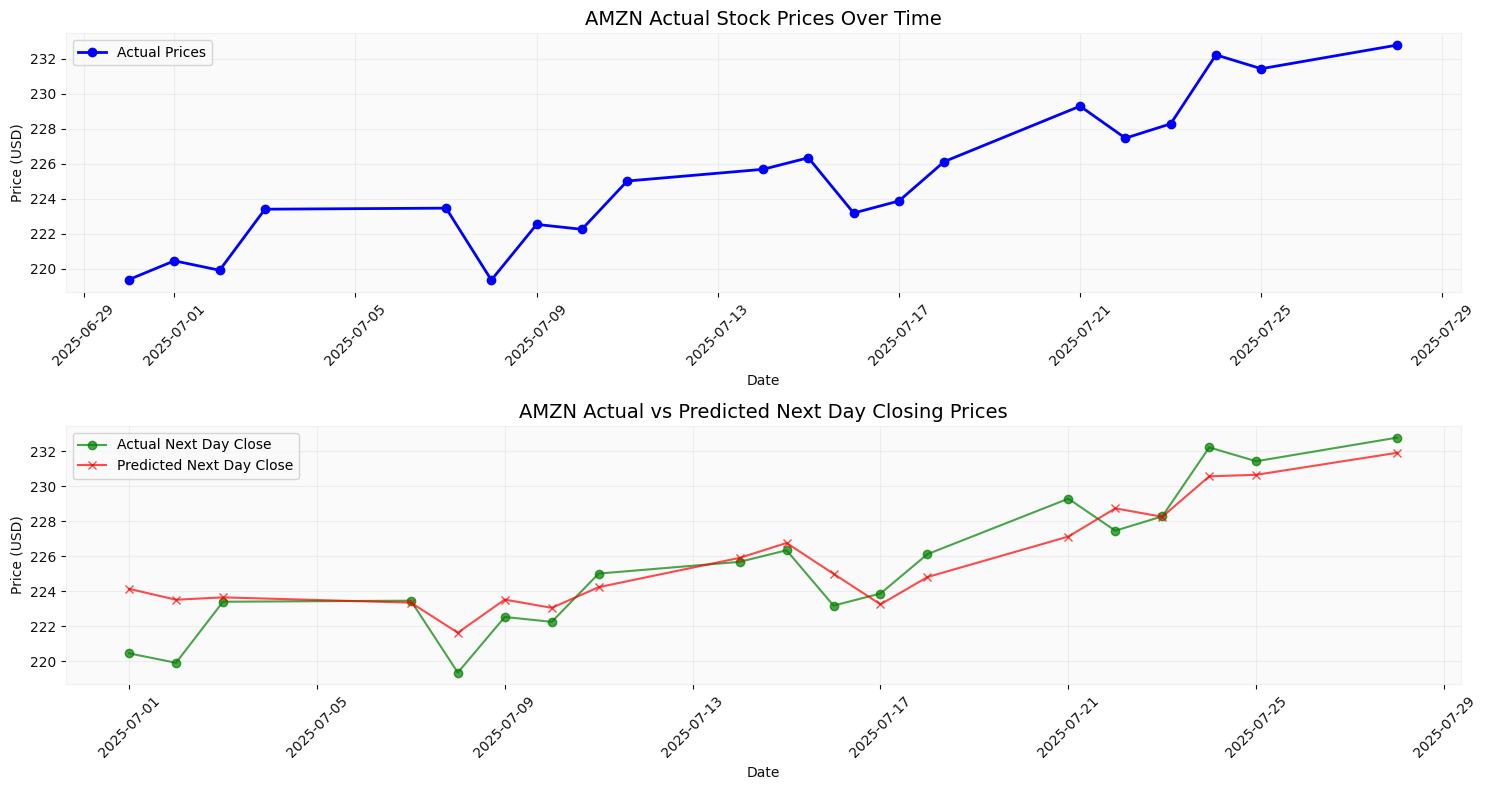


📊 MODEL PERFORMANCE SUMMARY
R² Score: -1.7504
⚠️  Negative R² indicates model performs worse than predicting the mean
Training data points: 19
Features used: Stock price + News sentiment
Algorithm: Random Forest Regressor


In [12]:
# Visualize actual vs predicted stock prices
import matplotlib.pyplot as plt

# Create predictions for all data points
all_predictions = model.predict(features)

# Create the visualization
plt.figure(figsize=(15, 8))

# Plot actual prices
plt.subplot(2, 1, 1)
plt.plot(data['Date'], data['Close_AMZN'], marker='o', linewidth=2, label='Actual Prices', color='blue')
plt.title(f'{ticker} Actual Stock Prices Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot actual vs predicted next-day prices
plt.subplot(2, 1, 2)
# Use dates from index 1 onwards since we're predicting next day
prediction_dates = data['Date'].iloc[1:]
plt.plot(prediction_dates, targets, marker='o', label='Actual Next Day Close', color='green', alpha=0.7)
plt.plot(prediction_dates, all_predictions, marker='x', label='Predicted Next Day Close', color='red', alpha=0.7)
plt.title(f'{ticker} Actual vs Predicted Next Day Closing Prices', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print model performance summary
print("\n" + "="*60)
print("📊 MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"R² Score: {model.score(X_test, y_test):.4f}")
if model.score(X_test, y_test) < 0:
    print("⚠️  Negative R² indicates model performs worse than predicting the mean")
elif model.score(X_test, y_test) < 0.3:
    print("📉 Low R² - Model has limited predictive power")
elif model.score(X_test, y_test) < 0.7:
    print("📊 Moderate R² - Model shows some predictive ability")
else:
    print("🎯 High R² - Model shows strong predictive ability")

print(f"Training data points: {len(features)}")
print(f"Features used: Stock price + News sentiment")
print(f"Algorithm: Random Forest Regressor")
print("="*60)